In [1]:
from os import listdir
from os.path import exists, join
import json

DATA_PATH = "../data"
OUTPUT_PATH = "../output_final/output"
DATASETS= ["Deco", "FusTe"]


refined_data = {}
for dataset in DATASETS:
    refined_file_path = join(DATA_PATH, dataset, "refined.json")
    with open(refined_file_path) as f:
        refined_data[dataset] = json.load(f)
        
annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "annotations_elements.json")
    with open(annotations_file_path) as f:
        annotation_data[dataset] = json.load(f)

def is_multi_key(key, dataset):
    try:
        return refined_data[dataset][key]["table_count"] > 2
    except KeyError:
        tables = [region for region in annotation_data[dataset][key]["regions"] if region["region_type"] == "Table"]
        return len(tables) > 2

def get_edge_count(key, dataset):
    return refined_data[dataset][key]["edge_count"]

def file_accuracies(experiment_path):
    """Returns the file accuracies for this experiment"""
    file_accuracies = {}
    for fold_num in range(10):
        accuracy_file_path = join(
            experiment_path,   
            f"fold_{fold_num}",
            f"fold_{fold_num}_file_accuracies.json",
        )

        if not exists(accuracy_file_path):
            # Fold was aborted
            continue
        with open(accuracy_file_path) as f:
            fold_file_accuracies = json.load(f)["fold_file_accuracies"]
            for key, accuracy in fold_file_accuracies.items():
                file_accuracies[key] = accuracy
    return file_accuracies

def has_noise(experiment_path):
    config_file_path = join(
            experiment_path,   
            "config.json",
        )
    with open(config_file_path) as f:
        noise = json.load(f)["noise"]
    return bool(noise)

def get_experiment_paths(dataset, noise):
    d = join(OUTPUT_PATH, dataset, "CrossValidationTraining")
    experiments = listdir(d)
    return [join(d, exp) for exp in experiments if has_noise(join(d, exp)) == noise]

In [2]:
from statistics import mean, stdev, StatisticsError

for dataset in DATASETS:
    print(dataset)
    for noise in [False, True]:
        noise_part = "" if not noise else " + N"
        print("\tGE" + noise_part)
        experiments = get_experiment_paths(dataset, noise)
        collected_accuracies = {}
        for exp in experiments:
            experimental_file_accuracies = file_accuracies(exp)
            for key, accuracy in experimental_file_accuracies.items():
                if accuracy > 1.0:
                    print(key)
                collected_accuracies[key] = collected_accuracies.get(key, []) + [accuracy]
        
        all_accuracies = {"1_10": [], "10_100": [], ">100": []}
        single_accuracies = {"1_10": [], "10_100": [], ">100": []}
        multi_accuracies = {"1_10": [], "10_100": [], ">100": []}
        for key, accuracies in collected_accuracies.items():
            edge_count = get_edge_count(key, dataset)
            edge_count_key = "1_10"
            if edge_count > 100:
                edge_count_key = ">100"
            elif 10 < edge_count <= 100:
                edge_count_key = "10_100"
            
            m = mean(accuracies)
            all_accuracies[edge_count_key].append(m)
            if is_multi_key(key, dataset):
                multi_accuracies[edge_count_key].append(m)
            else:
                single_accuracies[edge_count_key].append(m)
        
        for key in all_accuracies.keys():
            try:
                print(key)
                print(f"\t\tAll: {mean(all_accuracies[key])} +- {stdev(all_accuracies[key])}")
                print(f"\t\tAll min: {min(all_accuracies[key])} max: {max(all_accuracies[key])}")
                print(f"\t\tSingle: {mean(single_accuracies[key])} +- {stdev(single_accuracies[key])}")
                print(f"\t\tMulti: {mean(multi_accuracies[key])} +- {stdev(multi_accuracies[key])}")
            except StatisticsError:
                pass

Deco
	GE
1_10
		All: 0.949469964664311 +- 0.206767671928107
		All min: 0.0 max: 1.0
		Single: 0.9627594627594628 +- 0.1783210675212902
		Multi: 0.5866666666666667 +- 0.47640630029730185
10_100
		All: 0.709940794499618 +- 0.3446372393366323
		All min: 0.0 max: 1.0
		Single: 0.7591036414565826 +- 0.3223925145271805
		Multi: 0.39370410326292676 +- 0.3177961388002863
>100
		All: 0.716087962962963 +- 0.3639449808898314
		All min: 0.0 max: 1.0
		Single: 0.8240740740740741 +- 0.27551489183969124
		Multi: 0.13296296296296298 +- 0.17997993080213395
	GE + N
1_10
		All: 0.9477031802120142 +- 0.2108129631664594
		All min: 0.0 max: 1.0
		Single: 0.9597069597069597 +- 0.1841459142453265
		Multi: 0.62 +- 0.4939635614091388
10_100
		All: 0.7097539258127493 +- 0.3434347395648083
		All min: 0.0 max: 1.0
		Single: 0.7556022408963585 +- 0.32392327544885835
		Multi: 0.4148377368965604 +- 0.32195906316233747
>100
		All: 0.7166666666666667 +- 0.36589357867438443
		All min: 0.0 max: 1.0
		Single: 0.8117283950

Trying to investigate why multi table precision is so much lower than in the paper

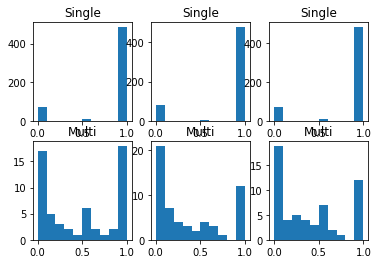

In [3]:
import matplotlib.pyplot as plt
fg, axes = plt.subplots(2, 3)
for i, experiment in enumerate(get_experiment_paths("Deco", True)):
    multi_table = [(key, acc) for key, acc in file_accuracies(experiment).items() if is_multi_key(key, "Deco")]
    single_table = [(key, acc) for key, acc in file_accuracies(experiment).items() if not is_multi_key(key, "Deco")]
    
    multi_table = (sorted(multi_table, key=lambda x: x[1]))
    single_table = (sorted(single_table, key=lambda x: x[1]))
    
    axes[0][i].hist([v for _, v in single_table])
    axes[0][i].set_title("Single")
    axes[1][i].hist([v for _, v in multi_table])
    axes[1][i].set_title("Multi")
    


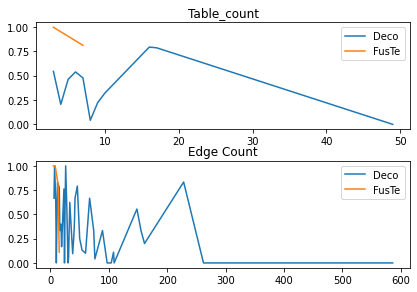

In [4]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout()
for j, dataset in enumerate(DATASETS):
    accuracies = {}
    table_counts = {}
    edge_counts = {}
    for seed, experiment in enumerate(get_experiment_paths(dataset, True)):
        for key, acc in file_accuracies(experiment).items():
            if not is_multi_key(key, dataset):
                continue
            accuracies[key] = accuracies.get(key, []) + [acc]
            table_counts[key] = refined_data[dataset][key]["table_count"]
            edge_counts[key] = refined_data[dataset][key]["edge_count"]
        
    for key, accs in accuracies.items():
        accuracies[key] = mean(accs)
    
    
    table_count_to_accs = {}
    for key, tc in table_counts.items():
        table_count_to_accs[tc] = table_count_to_accs.get(tc, []) + [accuracies[key]]

    for key, accs in table_count_to_accs.items():
        table_count_to_accs[key] = mean(accs)

    edge_counts_to_accs = {}
    for key, ec in edge_counts.items():
        edge_counts_to_accs[ec] = edge_counts_to_accs.get(ec, []) + [accuracies[key]]
    
    for key, accs in edge_counts_to_accs.items():
        edge_counts_to_accs[key] = mean(accs)
    
    table_count_and_acc = sorted(table_count_to_accs.items(), key=lambda x: x[0])
    edge_counts_and_acc = sorted(edge_counts_to_accs.items(), key=lambda x: x[0])
    
    ax1.plot([x[0] for x in table_count_and_acc], [x[1] for x in table_count_and_acc], label=dataset)
    ax1.set_title("Table_count")
    ax2.plot([x[0] for x in edge_counts_and_acc], [x[1] for x in edge_counts_and_acc], label=dataset)
    ax2.set_title("Edge Count")
ax1.legend()
ax2.legend()

Distribution EdgeCount Single Table File Multi Table File

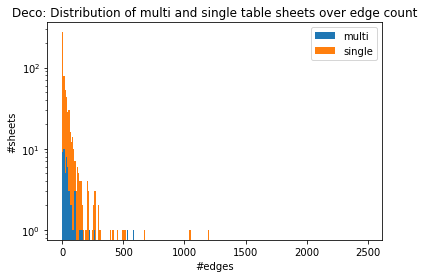

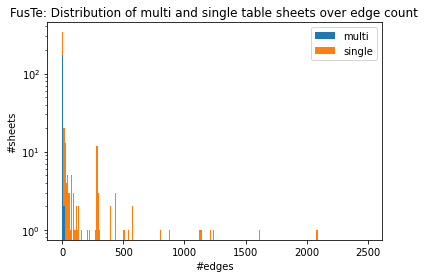

In [5]:
import matplotlib.pyplot as plt

for dataset in DATASETS:
    edge_counts_muti_table = []
    edge_counts_single_table = []
    for file_key, data in refined_data[dataset].items():
        edge_count = get_edge_count(file_key, dataset)
        if is_multi_key(file_key, dataset):
            edge_counts_muti_table.append(edge_count)
        else:
            edge_counts_single_table.append(edge_count)
    
    fig, ax = plt.subplots()

    ax.hist(
        [edge_counts_muti_table, edge_counts_single_table],
        stacked=True,
        label=["multi", "single"],
        bins=[i * 10 for i in range(250)]
    )

    ax.set_ylabel('#sheets')
    ax.set_yscale("log")
    ax.set_xlabel('#edges')
    ax.set_title(f'{dataset}: Distribution of multi and single table sheets over edge count')
    ax.legend()

    plt.show()

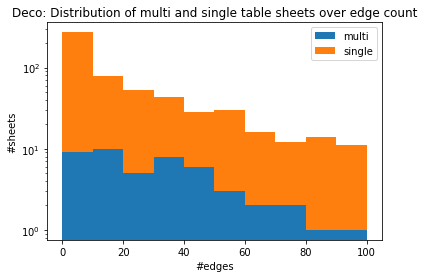

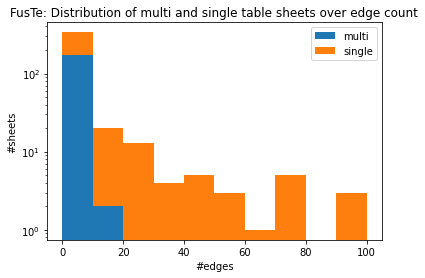

In [6]:
import matplotlib.pyplot as plt

for dataset in DATASETS:
    edge_counts_muti_table = []
    edge_counts_single_table = []
    for file_key, data in refined_data[dataset].items():
        edge_count = get_edge_count(file_key, dataset)
        if is_multi_key(file_key, dataset):
            edge_counts_muti_table.append(edge_count)
        else:
            edge_counts_single_table.append(edge_count)
    
    fig, ax = plt.subplots()

    ax.hist(
        [edge_counts_muti_table, edge_counts_single_table],
        stacked=True,
        label=["multi", "single"],
        bins=[i * 10 for i in range(11)]
    )

    ax.set_ylabel('#sheets')
    ax.set_yscale("log")
    ax.set_xlabel('#edges')
    ax.set_title(f'{dataset}: Distribution of multi and single table sheets over edge count')
    ax.legend()

    plt.show()

Getting an estimate on whether label region count correlates with "multi table"ism 

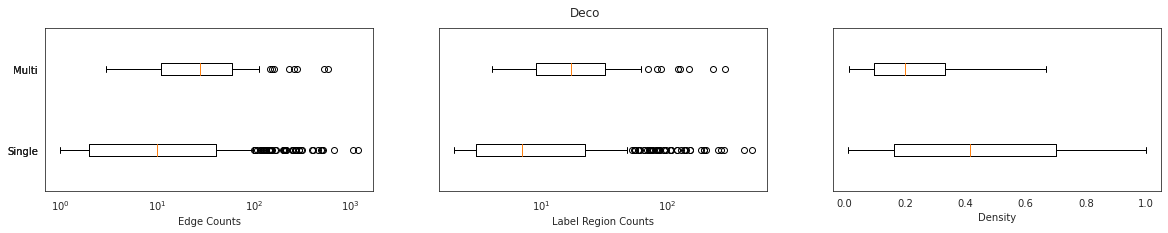

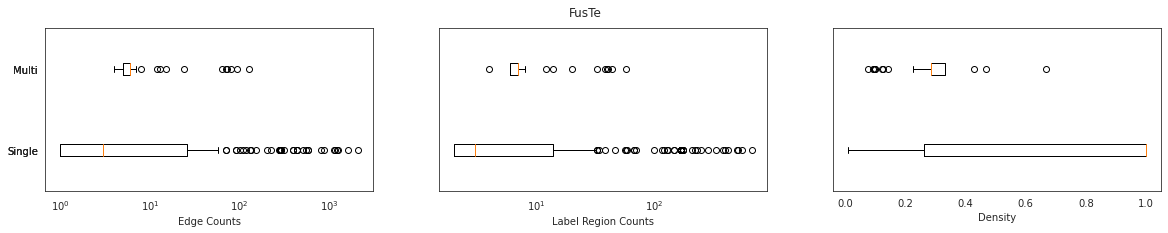

In [113]:

plt.rcParams["figure.figsize"] = (20,3)

for dataset in DATASETS:
    
    single_label_region_counts = []
    single_edge_counts = []
    single_densities = []
    
    multi_label_region_counts = []
    multi_edge_counts = []
    multi_densities = []
    
    for file_key, data in refined_data[dataset].items():
        table_count = data["table_count"]
        label_region_count = data["label_region_count"]
        edge_count = data["edge_count"]

        if table_count == 1:
            single_label_region_counts.append(label_region_count)
            single_edge_counts.append(edge_count)
            single_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
        else:
            multi_label_region_counts.append(label_region_count)
            multi_edge_counts.append(edge_count)
            multi_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(single_edge_counts, [1 for _ in range(len(single_edge_counts))], alpha=0.5, label="Single")
    ax1.scatter(multi_edge_counts, [2 for _ in range(len(multi_edge_counts))], alpha=0.5, label="Multi")
    ax1.set_xlabel("Edge Counts")
    ax1.legend()
    
    ax2.scatter(single_label_region_counts, [1 for _ in range(len(single_label_region_counts))], alpha=0.5, label="Single")
    ax2.scatter(multi_label_region_counts, [2 for _ in range(len(multi_label_region_counts))], alpha=0.5, label="Multi")
    ax2.set_xlabel("Label Region Counts")
    ax2.legend()
    
    ax3.scatter(single_densities, [1 for _ in range(len(single_densities))], alpha=0.5, label="Single")
    ax3.scatter(multi_densities, [2 for _ in range(len(multi_densities))], alpha=0.5, label="Multi")
    ax3.set_xlabel("Density")
    ax3.legend()

    fig.suptitle(dataset)
    """ 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    ax1.boxplot([single_edge_counts, multi_edge_counts], labels=["Single", "Multi"], vert=False)
    ax1.set_xlabel("Edge Counts")
    ax1.set_xscale("log")
    
    ax2.boxplot([single_label_region_counts, multi_label_region_counts], labels=["Single", "Multi"], vert=False)
    ax2.set_xlabel("Label Region Counts")
    ax2.set_xscale("log")
    
    ax3.boxplot([single_densities, multi_densities], labels=["Single", "Multi"], vert=False)
    ax3.set_xlabel("Density")
    fig.suptitle(dataset)